In [1]:
import sys

sys.path.append("../src")

In [2]:
import shutil
import importlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import lib
importlib.reload(lib)

<module 'lib' from '/Users/r/Documents/stud/ss24/finnpinn/src/lib.py'>

In [3]:
MAX_EPOCHS = 100
MIN_EPOCHS = 5

root_dir = Path(
    "/Users/r/Documents/dev/tmp/finn_repo_comparisions/cogni_finn/sampling/finndirs/"
)
root_dir.exists()

GROUND_TRUTH_Y = {
    "Core 1": lib.load_exp_data_numpy("Core 1")[1],
    "Core 2": lib.load_exp_data_numpy("Core 2")[1],
    "Core 2B": lib.load_exp_data_numpy("Core 2B")[1],
    # There is no ground truth for "Ret"
}
GROUND_TRUTH_X = {
    "Core 1": lib.load_exp_data_numpy("Core 1")[0],
    "Core 2": lib.load_exp_data_numpy("Core 2")[0],
    "Core 2B": lib.load_exp_data_numpy("Core 2B")[0],
    "Ret": np.linspace(0, 2, 501),
}

for k,v in GROUND_TRUTH_Y.items():
    print(k, v.shape)

Core 1 (50,)
Core 2 (55,)
Core 2B (21,)


In [17]:
def btc_from_full_field(c_full) -> np.ndarray:
    core2_cfg = lib.FinnParams.from_dict(
        is_exp_data=True, **lib.load_exp_conf("Core 2")
    )

    A = np.pi * 0.02375**2
    Q = 0.00010435199999999999
    cm = lib.load_exp_conf("Core 2")["por"] * A / Q
    cauchy_mult = cm * core2_cfg.D_eff[0] * core2_cfg.dx
    btc = (c_full[1:, -2, 0] - c_full[1:, -1, 0]) * cauchy_mult
    return btc


def compute_scaling_factor(y_true, y_pred) -> float:
    return 1.0
    v = np.var(y_true)
    if v == 0.0:
        v = np.max(np.abs(y_true)) ** 2
    if v == 0.0:
        v = np.max(np.abs(y_pred)) ** 2
    if v == 0.0:
        return 0.0
    return 1.0 / float(v)


def calculate_nmse(y_true, y_pred) -> float:
    s = compute_scaling_factor(y_true, y_pred)
    return s * np.mean((y_true - y_pred) ** 2)


def calculate_nmae(y_true, y_pred) -> float:
    s = compute_scaling_factor(y_true, y_pred)
    return s * np.max(np.abs(y_true - y_pred))


def load_epoch_data(directory, epoch: int) -> dict[str, np.ndarray]:
    """Loads data for a single epoch from a directory."""
    directory = Path(directory)

    def get_arr(arr_type: str) -> np.ndarray:
        if arr_type == "Core 1":
            return np.load(directory / f"core1BTC_{epoch}.npy")
        if arr_type == "Core 2":
            return np.concatenate([[0.0], btc_from_full_field(np.load(directory / f"cPred_{epoch}.npy"))])
        if arr_type == "Core 2B":
            return np.load(directory / f"cProfile_{epoch}.npy")
        if arr_type == "Ret":
            return np.load(directory / f"retPred_{epoch}.npy")
        else:
            raise ValueError(f"Unknown array type: '{arr_type}'")

    data = {}
    try:
        for core_type in ["Core 1", "Core 2", "Core 2B", "Ret"]:
            data[core_type] = get_arr(core_type)
    except FileNotFoundError as e:
        raise e
    assert len(data) == len(GROUND_TRUTH_X), len(data)
    return data


def preprocess_directory(directory) -> None:
    """Preprocesses a single directory, stacking data and removing if insufficient epochs."""
    directory = Path(directory)

    if len(list(directory.glob("*_all.npy"))) == len(GROUND_TRUTH_X):
        return

    all_data = {}
    for epoch in range(MAX_EPOCHS):
        try:
            epoch_data = load_epoch_data(directory, epoch)
        except FileNotFoundError:
            continue
        for core_type, data in epoch_data.items():
            all_data.setdefault(core_type, []).append(data)

    if len(all_data.get("Core 1", [])) < MIN_EPOCHS:
        # shutil.rmtree(directory)
        print(f"Bad directory: {directory.relative_to(root_dir)}")
        return

    print("Saving data...")
    for core_type, data_list in all_data.items():
        stacked_data = np.stack(data_list, axis=0)
        np.save(directory / f"{core_type.replace(' ', '')}_all.npy", stacked_data)


def load_preprocessed_data(directory) -> dict[str, np.ndarray]:
    """Loads preprocessed, stacked data from a directory."""
    data = {}
    for core_type in ["Core 1", "Core 2", "Core 2B", "Ret"]:
        data[core_type] = np.load(directory / f"{core_type.replace(' ', '')}_all.npy")
    return data


def is_arr_bad(arr: np.ndarray, max_val=1e10) -> bool:
    if np.isinf(arr).any():
        return True
    if np.isnan(arr).any():
        return True
    if (np.abs(arr) > max_val).any():
        return True
    return False


def is_valid_epoch(
    predictions: dict[str, np.ndarray], metrics_thresholds: dict[tuple[str, str], float]
) -> bool:
    """Checks if predictions for a single epoch meet criteria."""
    for core_type, y_pred in predictions.items():
        if is_arr_bad(y_pred):
            return False

        if core_type == "Ret":
            continue

        y_true = GROUND_TRUTH_Y[core_type]
        if is_arr_bad(y_true):
            return False

        # ignore core 2B outlier in error computation
        if core_type == "Core 2B":
            y_true = y_true[1:]
            y_pred = y_pred[1:]

        if calculate_nmse(y_true, y_pred) > metrics_thresholds[("NMSE", core_type)]:
            return False
        if calculate_nmae(y_true, y_pred) > metrics_thresholds[("NMAE", core_type)]:
            return False

    return True


def is_sufficiently_different(
    ret_curve: np.ndarray,
    other_ret_curves: list[np.ndarray],
    difference_thresholds: dict[str, float],
):
    """Checks if a retardation curve is sufficiently different from others."""
    for other_curve in other_ret_curves:
        if calculate_nmae(ret_curve, other_curve) < difference_thresholds["NMAE"]:
            return False
        if calculate_nmse(ret_curve, other_curve) < difference_thresholds["NMSE"]:
            return False
    return True

import json
from typing import Any
def collect_valid_predictions(
    directories, metrics_thresholds: dict[tuple[str, str], float]
) -> tuple[dict[str, np.ndarray], list[Path], list[dict[str, Any]]]:
    """Collects valid predictions across all directories."""

    ret_thresholds = {t[0]: v for t, v in metrics_thresholds.items() if t[1] == "Ret"}

    valid_predictions: dict[str, list[np.ndarray]] = dict()

    valid_dirs = []
    params = []
    for k, directory in enumerate(directories):
        print(
            f"({k+1}/{len(directories)}): Processing {directory.relative_to(root_dir)}"
        )

        dir_data = load_preprocessed_data(directory)

        valid_rets_this_dir: list[np.ndarray] = []
        for epoch in range(dir_data["Core 1"].shape[0]):
            predictions = {
                core_type: dir_data[core_type][epoch] for core_type in dir_data
            }

            if not is_valid_epoch(predictions, metrics_thresholds):
                continue

            # if ret is not sufficiently different, it makes no sense to include it because this would change the distribution but only because it is correlated
            if not is_sufficiently_different(
                predictions["Ret"],
                valid_rets_this_dir,
                ret_thresholds,
            ):
                continue

            valid_rets_this_dir.append(predictions["Ret"])
            params.append(json.loads((directory / "config.json").read_text()))
            params[-1]["epoch"] = epoch
            for k, v in predictions.items():
                valid_predictions.setdefault(k, []).append(v)

        if not valid_rets_this_dir:
            print("    Invalid - No valid epochs found.")
            continue
        else:
            print(f"    Valid - {len(valid_rets_this_dir)} epoch(s) found.")
            valid_dirs.append(Path(directory))

    return {k: np.vstack(v) for k, v in valid_predictions.items()}, valid_dirs, params

In [18]:
metrics_thresholds = {
    # ("NMSE", "Core 1"): 2*1e-7/2,
    # ("NMAE", "Core 1"): 2*0.001,
    ("NMSE", "Core 1"): 1e10,
    ("NMAE", "Core 1"): 1e10,

    ("NMSE", "Core 2"): 1e-7/3,
    ("NMAE", "Core 2"): 0.002,

    ("NMSE", "Core 2B"): 1e10,
    ("NMAE", "Core 2B"): 1e10,
    # ("NMSE", "Core 2B"): 10000*1e-7/2,
    # ("NMAE", "Core 2B"): 10000*0.001,

    ("NMSE", "Ret"): 8*1e-4,
    ("NMAE", "Ret"): 4*1e-4,
    # ("NMSE", "Ret"): 1e10,
    # ("NMAE", "Ret"): 1e10,
}

directories = [p.parent for p in root_dir.rglob("y_train.npy")]
print(len(directories))
list(map(preprocess_directory, directories))
directories = [p.parent for p in root_dir.rglob("*_all.npy")]#[8:9]
print(len(directories))

valid_curves, valid_dirs, valid_params = collect_valid_predictions(directories, metrics_thresholds)

81
Bad directory: 66352512
Bad directory: 72362912
Bad directory: 84789408
Bad directory: 46656512
Bad directory: 60711680
304
(1/304): Processing 64583616
    Invalid - No valid epochs found.
(2/304): Processing 64583616
    Invalid - No valid epochs found.
(3/304): Processing 64583616
    Invalid - No valid epochs found.
(4/304): Processing 64583616
    Invalid - No valid epochs found.
(5/304): Processing 57691584
    Invalid - No valid epochs found.
(6/304): Processing 57691584
    Invalid - No valid epochs found.
(7/304): Processing 57691584
    Invalid - No valid epochs found.
(8/304): Processing 57691584
    Invalid - No valid epochs found.
(9/304): Processing 25608000
    Valid - 4 epoch(s) found.
(10/304): Processing 25608000
    Valid - 4 epoch(s) found.
(11/304): Processing 25608000
    Valid - 4 epoch(s) found.
(12/304): Processing 25608000
    Valid - 4 epoch(s) found.
(13/304): Processing 93796192
    Invalid - No valid epochs found.
(14/304): Processing 93796192
    Inval

In [ ]:
# needed for sensitivity analysis
import pandas as pd


valid_params_df = pd.DataFrame.from_records(valid_params)
processed_expdata_dir = Path("../data_processed/experimental/SPAN")
np.save(processed_expdata_dir / "params.npy", valid_params_df.to_numpy(), allow_pickle=False)

display(valid_params_df)
display(valid_params_df.to_numpy())

,seed,loss_phys_fac,loss_mse_fac,epoch
0,25608000,23972.056948,8.697077e+06,4
1,25608000,23972.056948,8.697077e+06,6
2,25608000,23972.056948,8.697077e+06,11
3,25608000,23972.056948,8.697077e+06,18
4,25608000,23972.056948,8.697077e+06,4
...,...,...,...,...
775,46069184,88449.448446,5.195929e+02,5
776,46069184,88449.448446,5.195929e+02,4
777,46069184,88449.448446,5.195929e+02,5
778,46069184,88449.448446,5.195929e+02,4


array([[2.56080000e+07, 2.39720569e+04, 8.69707723e+06, 4.00000000e+00],
       [2.56080000e+07, 2.39720569e+04, 8.69707723e+06, 6.00000000e+00],
       [2.56080000e+07, 2.39720569e+04, 8.69707723e+06, 1.10000000e+01],
       ...,
       [4.60691840e+07, 8.84494484e+04, 5.19592866e+02, 5.00000000e+00],
       [4.60691840e+07, 8.84494484e+04, 5.19592866e+02, 4.00000000e+00],
       [4.60691840e+07, 8.84494484e+04, 5.19592866e+02, 5.00000000e+00]])

In [6]:
processed_expdata_dir = Path("../data_processed/experimental/SPAN")
print()
for k, v in valid_curves.items():
    p = processed_expdata_dir / f"y_{k.replace(' ', '').lower()}_samples.npy"
    print(f"Saving {v.shape[0]} '{k}' samples to {p}")
#     np.save(p, v)
# np.save(processed_expdata_dir / "x_ret_samples.npy", GROUND_TRUTH_X["Ret"])


Saving 780 'Core 1' samples to ../data_processed/experimental/SPAN/y_core1_samples.npy
Saving 780 'Core 2' samples to ../data_processed/experimental/SPAN/y_core2_samples.npy
Saving 780 'Core 2B' samples to ../data_processed/experimental/SPAN/y_core2b_samples.npy
Saving 780 'Ret' samples to ../data_processed/experimental/SPAN/y_ret_samples.npy


In [7]:
# # old_rets = valid_curves["Ret"]
# print(old_rets.shape[0])
# fig, axs = plt.subplots(ncols=2)
# axs[0].plot(old_rets.T, "k-")
# axs[1].plot(valid_curves["Ret"].T, "k-")
# plt.show()

Core 1 (780, 50)
Core 2 (780, 55)
Core 2B (780, 21)
Ret (780, 501)


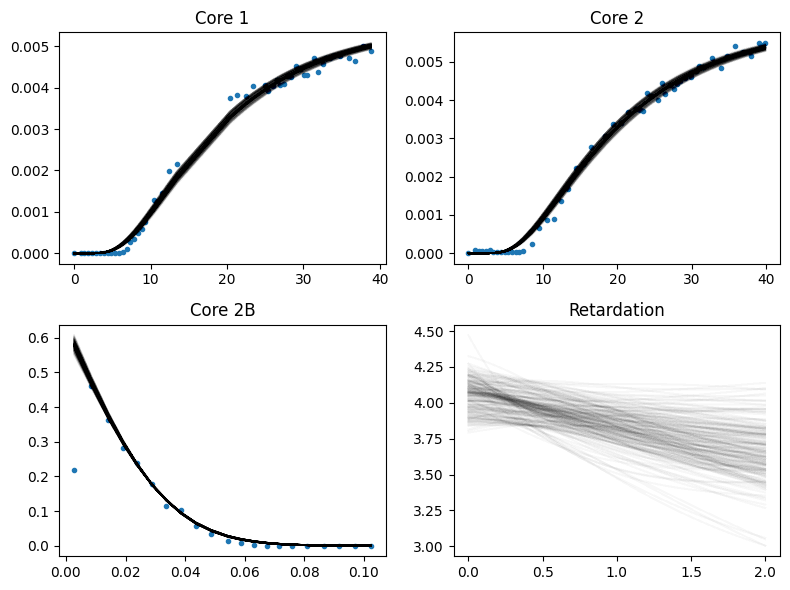

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axs = axs.flatten()


for i, (core_type, y) in enumerate(GROUND_TRUTH_Y.items()):
    axs[i].plot(GROUND_TRUTH_X[core_type], y, ".")
    axs[i].set_title(core_type)
axs[-1].set_title("Retardation")


for i, (core_type, curves) in enumerate(valid_curves.items()):
    if curves is None or curves.size < 1:
        continue

    print(core_type, curves.shape)
    alpha = min(1, 6 / curves.shape[0])
    # alpha = 1.0
    axs[i].plot(
        GROUND_TRUTH_X[core_type], curves.T, "k-", alpha=alpha
    )


plt.tight_layout()
plt.show()